# -------------------------------------------------------
# Titanic analysis and survival prediction model 
# -------------------------------------------------------

## 0. Load data
## 1. Data cleaning
## 2. Analysis
        2.1. Overview
        2.2. Sex, class and survival
        2.3. Siblings and children
        2.4. Boarding port
## 3. Predictive model
        3.1. Converting categorical features
        3.2. Building logistic regression model

In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
%matplotlib inline
sns.set_style('darkgrid')
colors = ["windows blue","amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))
sns.set_palette('hls')
sns.set_context("notebook", 1.5)
alpha = 0.7

# 0. Load data

In [187]:
test  = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [188]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [189]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [190]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [191]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Insights

1. Different number of rows in train and test.
2. The training set has Survived as variable but the test set not. We will predict from the training set if a passenger in test set survived or not.

# 1. Data cleaning

In the following figure it is plotted in yellow the Nan's values in both train and test datasets.

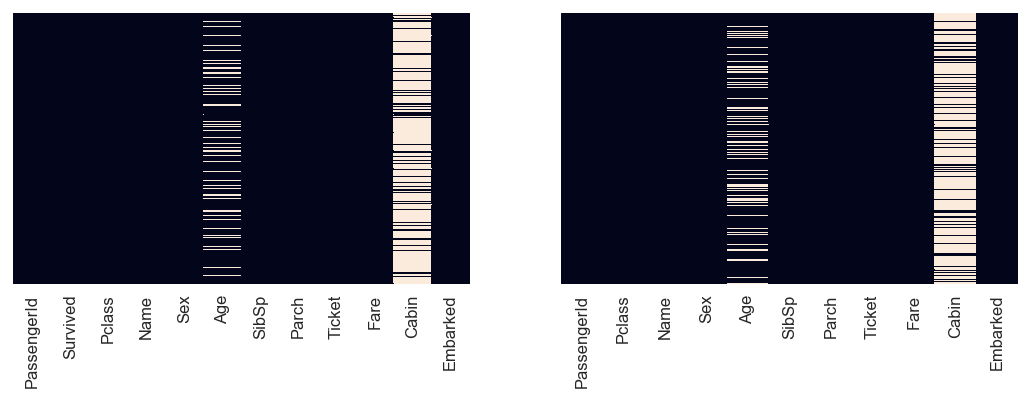

In [192]:
plt.figure(figsize=(18,5))
plt.subplot(121)
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)
plt.subplot(122)
sns.heatmap(test.isnull(), yticklabels=False, cbar=False)
plt.show()

Note that there are too many missing values in the Age column. We can fill these values from the information we have in this column. For example, we can calculate the average of the age per passenger class group and replace the age missing value of a passenger with the corresponding age per class he/she belongs. 

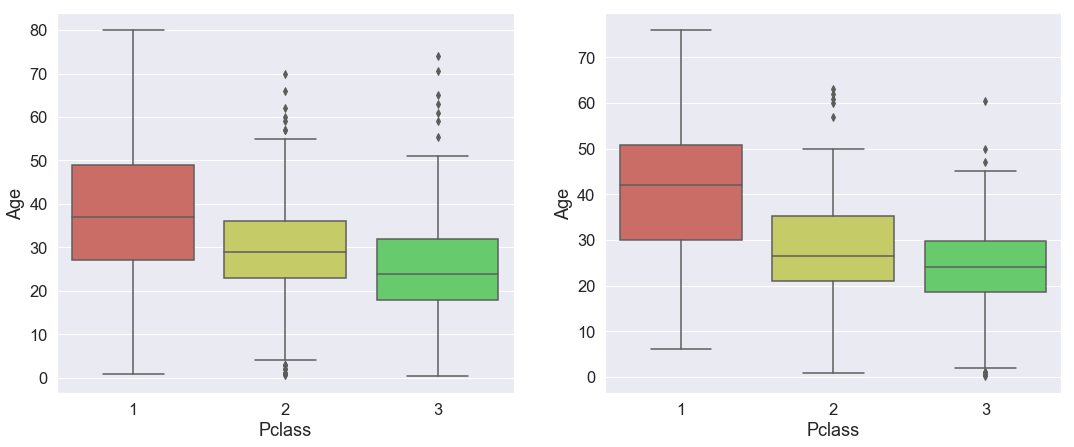

In [193]:
plt.figure(figsize=(18,7))
plt.subplot(121)
sns.boxplot(x='Pclass', y='Age', data=train)
plt.subplot(122)
sns.boxplot(x='Pclass', y='Age', data=test)
plt.show()

In [194]:
# Compute the average age per class using bot training and testing datasets. 
Age_Pclass1 = 0.5*(train[train['Pclass']==1]['Age'].mean() + test[test['Pclass']==1]['Age'].mean())
Age_Pclass2 = 0.5*(train[train['Pclass']==2]['Age'].mean() + test[test['Pclass']==2]['Age'].mean())
Age_Pclass3 = 0.5*(train[train['Pclass']==3]['Age'].mean() + test[test['Pclass']==3]['Age'].mean())

print(Age_Pclass1, Age_Pclass2, Age_Pclass3)

39.57590410357692 29.327565028901734 24.584282461894656


In [195]:
def imput_age(cols):
    
    Pclass = cols[0]
    Age = cols[1]

    if pd.isnull(Age):
        if Pclass==1:
            return Age_Pclass1      
        if Pclass==2:
            return Age_Pclass2
        else:
            return Age_Pclass3
    else:
        return Age

In [196]:
# Replace missing values
train['Age'] = train[['Pclass','Age']].apply(imput_age, axis=1)
test['Age'] = test[['Pclass','Age']].apply(imput_age, axis=1)

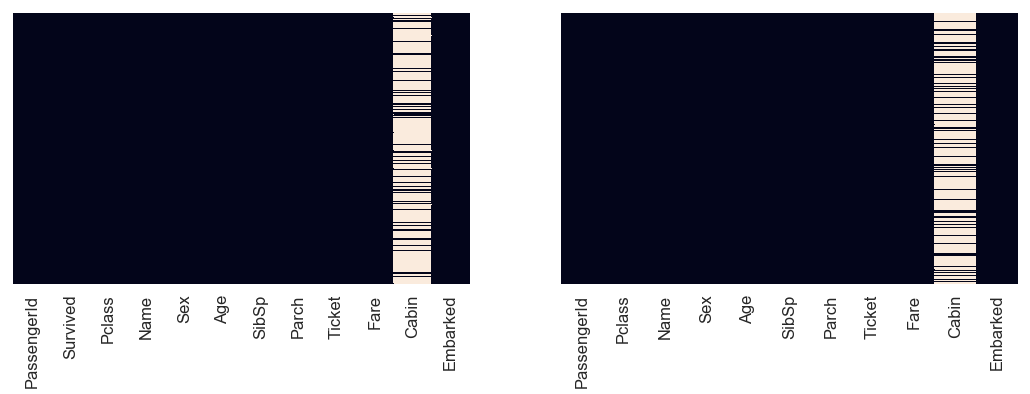

In [197]:
plt.figure(figsize=(18,5))
plt.subplot(121)
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)
plt.subplot(122)
sns.heatmap(test.isnull(), yticklabels=False, cbar=False)
plt.show()

Now we have no missing values in Age column. Cabin column has too many Nan's. We drop this column and the rows with Nan's that the test set has.

In [198]:
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)
test.dropna(inplace=True)

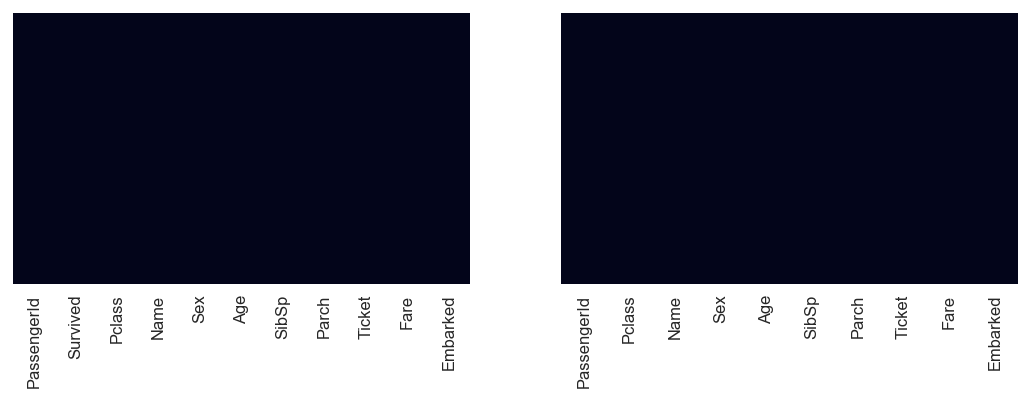

In [199]:
plt.figure(figsize=(18,5))
plt.subplot(121)
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)
plt.subplot(122)
sns.heatmap(test.isnull(), yticklabels=False, cbar=False)
plt.show()

Finally, we delete the columns we will not use: Name, Ticket.

In [200]:
train.drop(['Name','Ticket'], inplace=True, axis=1)
test.drop(['Name', 'Ticket'], inplace=True, axis=1)

In [201]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [202]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


# 2. Analysis

In the following section we will perform an analysis of the training set. We will use the test set in the prediction section to evaluate the model we will construct.

## 2.1. Overview

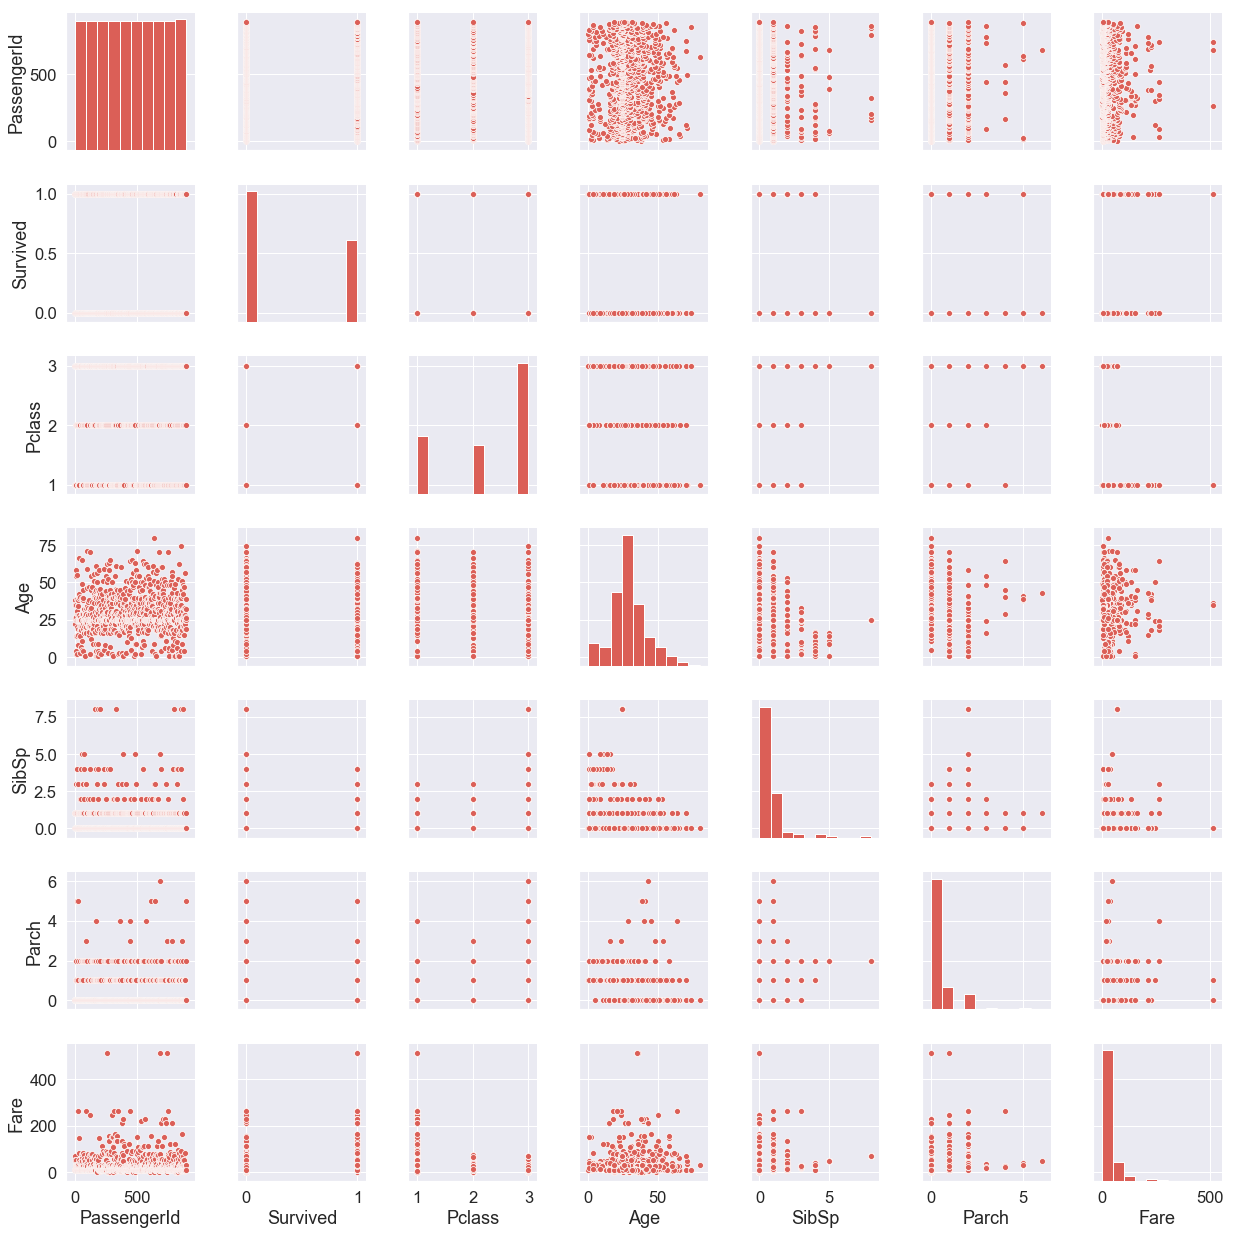

In [203]:
sns.pairplot(train)

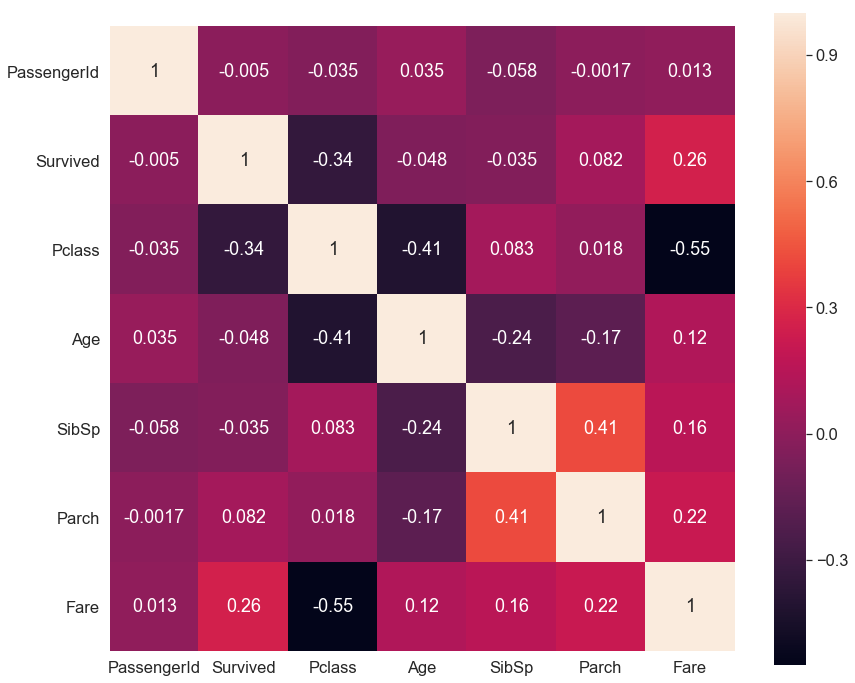

In [204]:
plt.figure(figsize=(14,12))
sns.heatmap(train.corr(), annot=True, square=True)

There are not many features strongly correlated. The most correlated is the number of sibling on board (SibSp) and the number of parents with children (Parch).

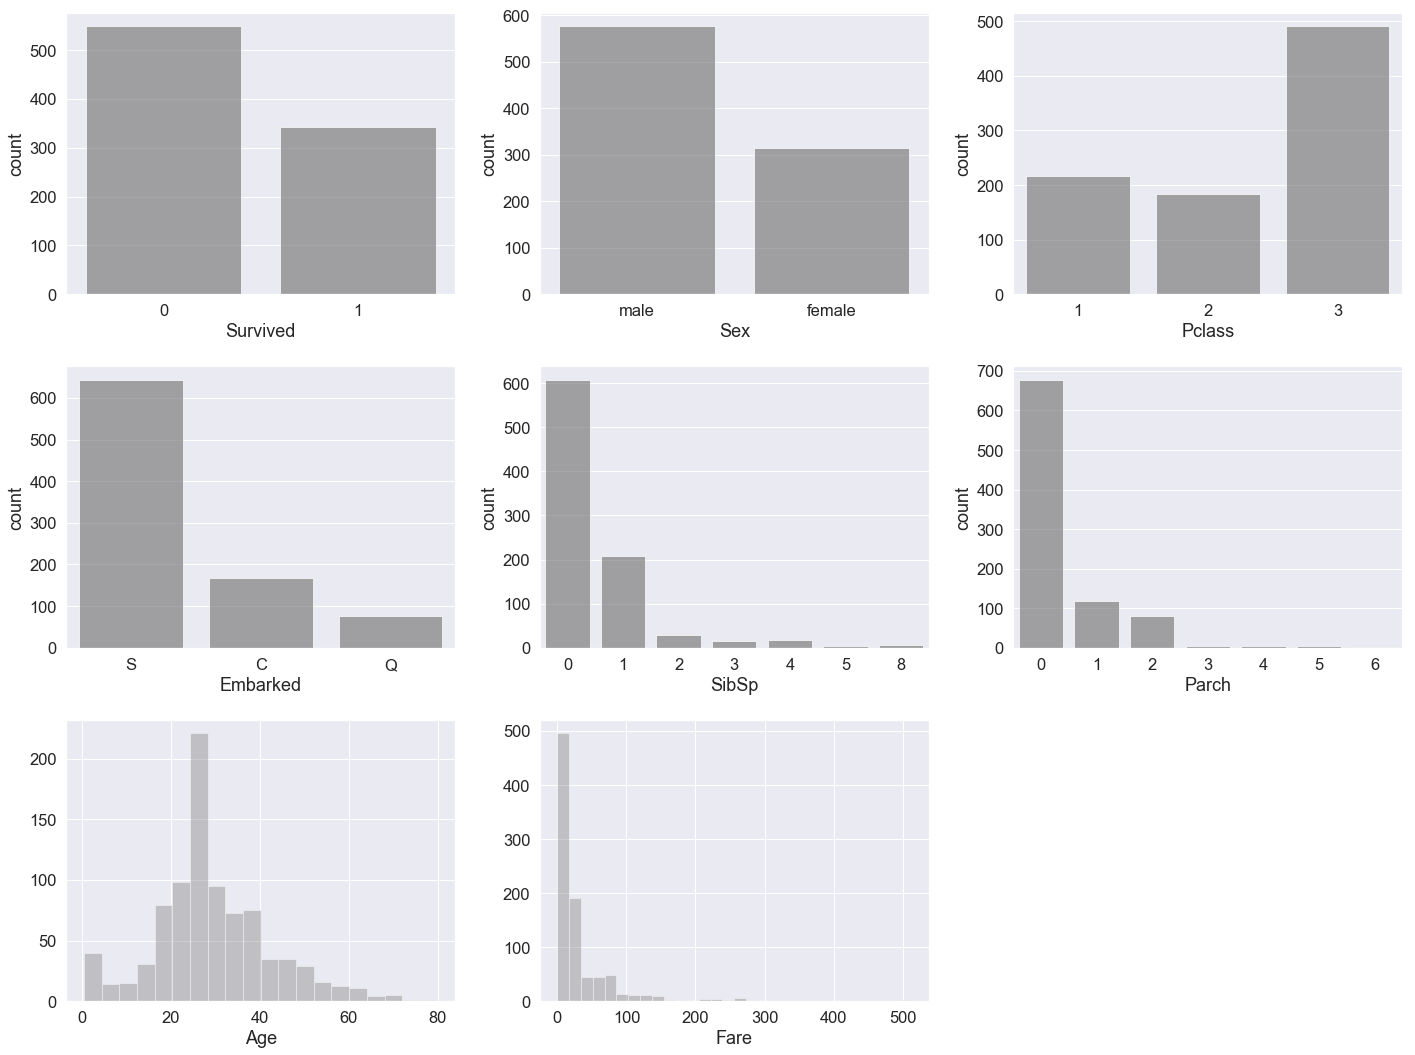

In [205]:
plt.figure(figsize=(20,15))
plt.subplot(331)
sns.countplot(x='Survived', data=train, color='grey', alpha=alpha)
plt.subplot(332)
sns.countplot(x='Sex', data=train, color='grey', alpha=alpha)
plt.subplot(333)
sns.countplot(x='Pclass', data=train, color='grey', alpha=alpha)
plt.subplot(334)
sns.countplot(x='Embarked', data=train, color='grey', alpha=alpha)
plt.subplot(335)
sns.countplot(x='SibSp', data=train, color='grey', alpha=alpha)
plt.subplot(336)
sns.countplot(x='Parch', data=train, color='grey', alpha=alpha)
plt.subplot(337)
sns.distplot(train['Age'], color='grey', kde=False, bins=20)
plt.subplot(338)
sns.distplot(train['Fare'], color='grey', kde=False, bins=30)

plt.tight_layout()

### General insights

1. The typical passenger profile is a single man in his twenties/thirties (without children or siblings on board) who traveled in third class and embarked in Southampton.
2. More people died than survived.
3. More men were on board than women. 
4. More passengers in third class than in the other two. In first and second class the numbr of passenger is quite similar. 
5. Passenger traveled alone or with one sibling. 
6. Few children were on board.

## 2.2. Sex, class and survival

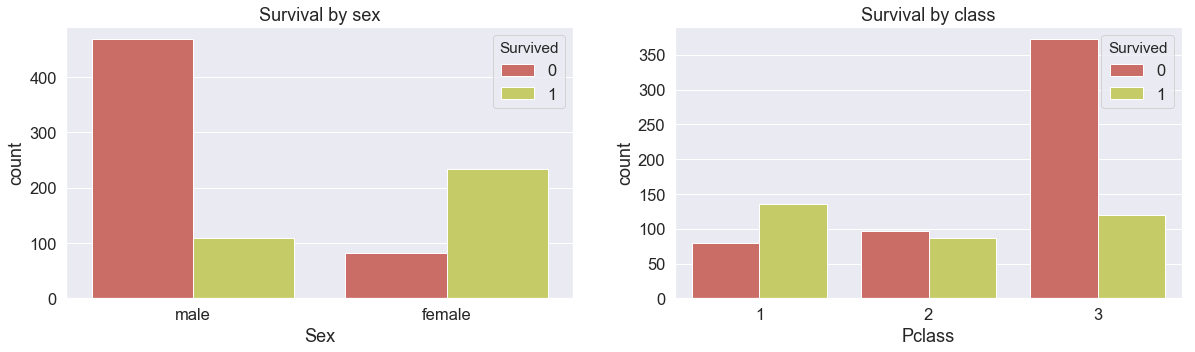

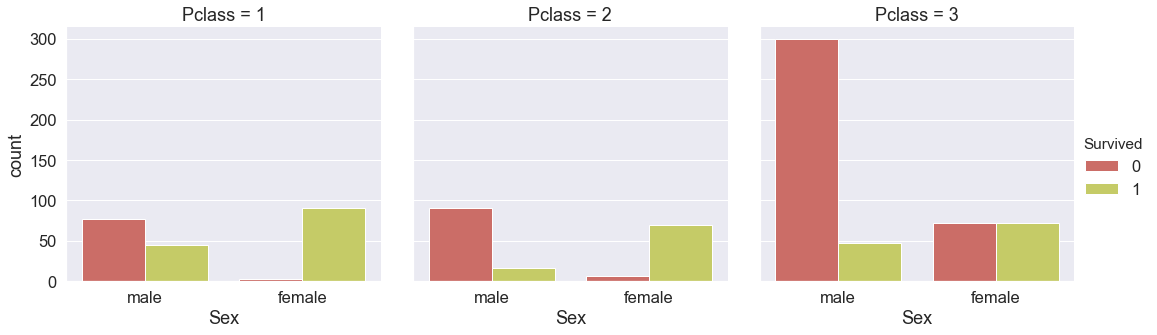

In [206]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.countplot(x='Sex', data=train, hue='Survived')
plt.title('Survival by sex')
plt.subplot(122)
sns.countplot(x='Pclass', data=train, hue='Survived')
plt.title('Survival by class')
plt.show()

sns.catplot(x='Sex', hue='Survived', col='Pclass', data=train, kind="count")
plt.show()

### Insights

1. The chance to live or to die depends on the the sex and the class. 
2. More men died than survived, but more women survived than died. In the third class the number of dead women is approximately equal to the number of women who survived.
3. The weight of the sex feature is higher than the weight of the class in order to predict the 'Survived' feature. A men probably died in the Titanic, but a women could survived even if she traveled in the third class. 

## 2.3. Siblings and children

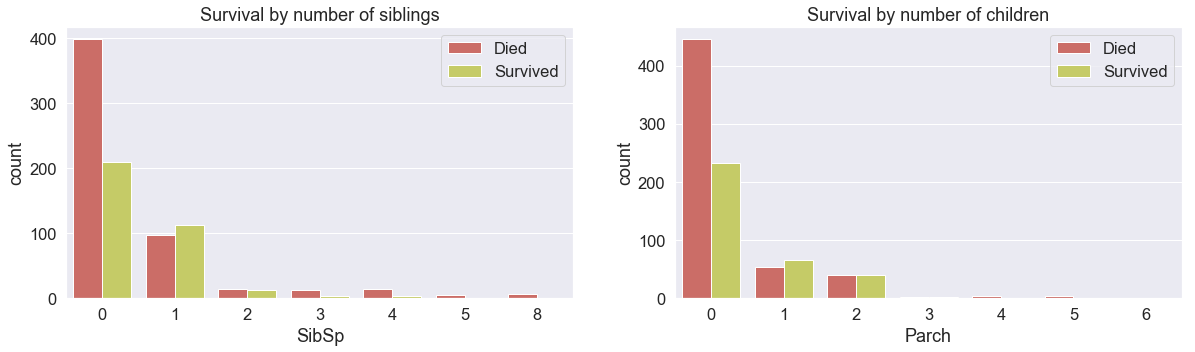

In [207]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.countplot(x='SibSp', data=train, hue='Survived')
plt.title('Survival by number of siblings')
plt.legend(['Died', 'Survived'], loc=1)
plt.subplot(122)
sns.countplot(x='Parch', data=train, hue='Survived')
plt.title('Survival by number of children')
plt.legend(['Died', 'Survived'], loc=1)
plt.show()

It seems that to have children (right figure) was an incentive to survive. I suppose that families had priority to board the lifeboat. Also, people who traveled with siblings were more likely to survive (left figure). Let's see if these insights are related to the sex and class features. 

### 2.3.1. Siblings

<Figure size 1440x360 with 0 Axes>

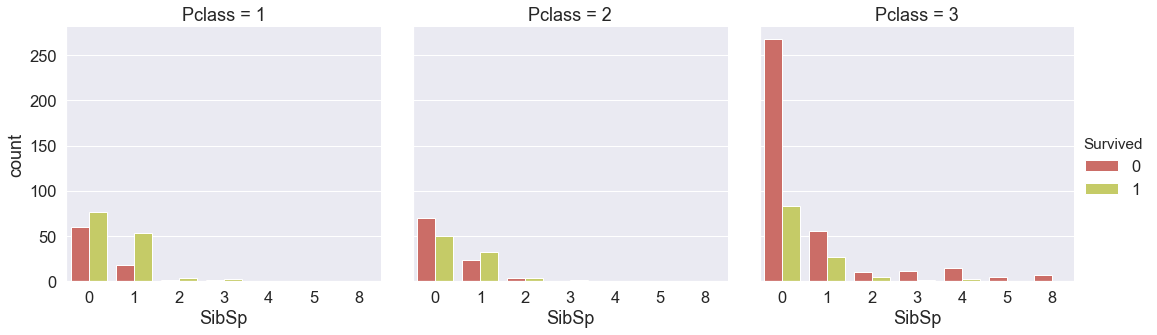

In [208]:
plt.figure(figsize=(20,5))
sns.catplot(x='SibSp', hue='Survived', col='Pclass', data=train, kind="count")
plt.show()

Therefore, people who traveled whit siblings were more likely to survive but not if they belonged to the third class. 

<Figure size 1440x360 with 0 Axes>

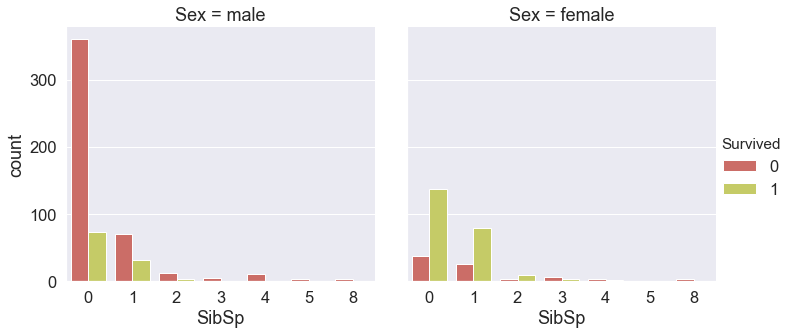

In [209]:
plt.figure(figsize=(20,5))
sns.catplot(x='SibSp', hue='Survived', col='Sex', data=train, kind="count")
plt.show()

Again the sex is crucial to figure out if one survived or not. Let's mix class and sex in order to obtain some insights 

In [210]:
train_1class = train[train['Pclass']==1]
train_2class = train[train['Pclass']==2]
train_3class = train[train['Pclass']==3]

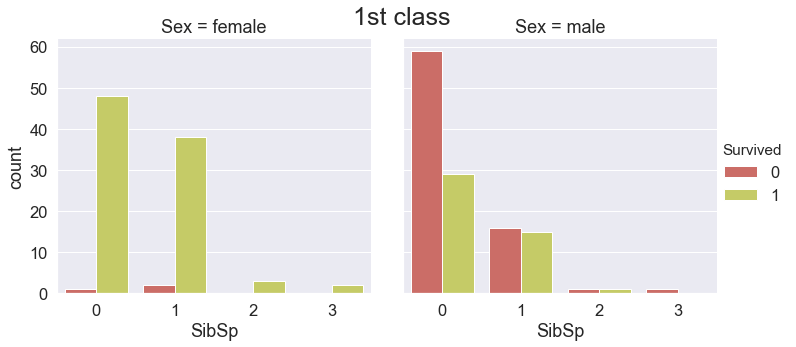

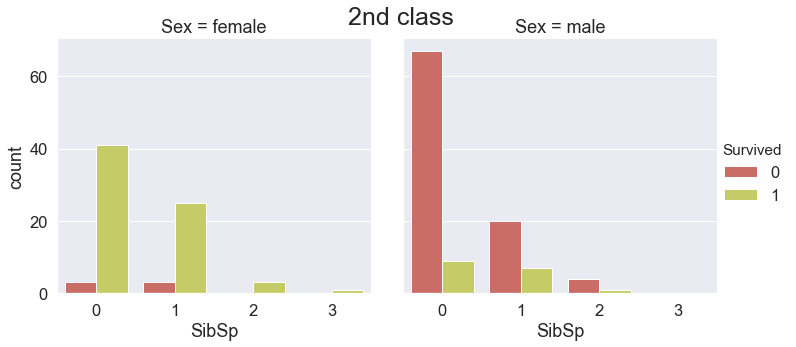

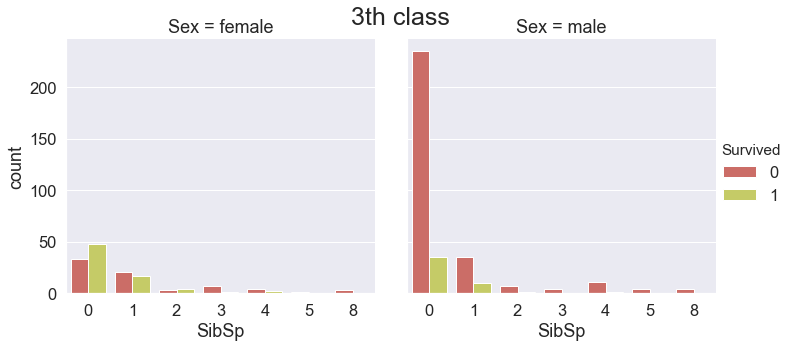

In [211]:
g=sns.catplot(x='SibSp', hue='Survived', col='Sex', data=train_1class, kind='count')
g.fig.suptitle('1st class', fontsize=25)
plt.show()
g=sns.catplot(x='SibSp', hue='Survived', col='Sex', data=train_2class, kind='count')
g.fig.suptitle('2nd class', fontsize=25)
plt.show()
g=sns.catplot(x='SibSp', hue='Survived', col='Sex', data=train_3class, kind='count', col_order=['female', 'male'])
g.fig.suptitle('3th class', fontsize=25)
plt.show()

### Insights for siblings

1. At first glance it seems that to have siblings is important to survive.
2. This is only true for women belonged to the first and second class. Men died independently of the number of siblings. 
3. Third class women wihtout sibling were more likely to survive.

Let's move now to analyze the importance of the size of the family (Parch)

### 2.3.1. Family size 

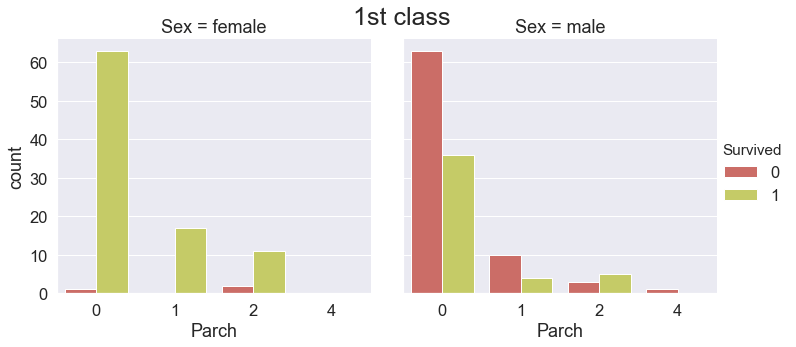

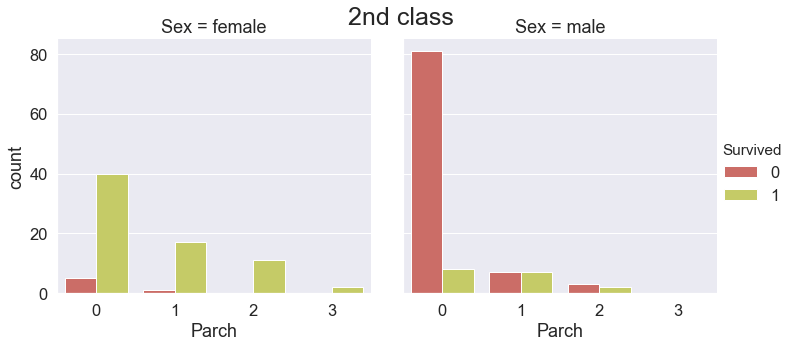

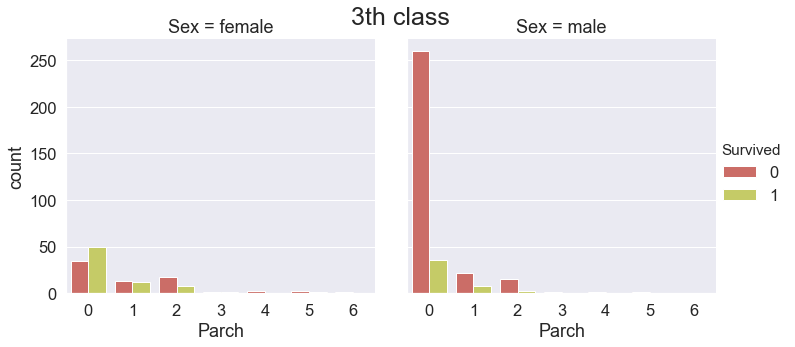

In [212]:
g=sns.catplot(x='Parch', hue='Survived', col='Sex', data=train_1class, kind='count')
g.fig.suptitle('1st class', fontsize=25)
plt.show()
g=sns.catplot(x='Parch', hue='Survived', col='Sex', data=train_2class, kind='count')
g.fig.suptitle('2nd class', fontsize=25)
plt.show()
g=sns.catplot(x='Parch', hue='Survived', col='Sex', data=train_3class, kind='count', col_order=['female', 'male'])
g.fig.suptitle('3th class', fontsize=25)
plt.show()

### Insights for family size

1. It seems that to have children is important to survive.
2. This is only true for women belonged to the first and second class. Men died independently of the number of children.
3. Again, third class women who traveled alone were more likely to survived. 

## 2.4. Boarding port 

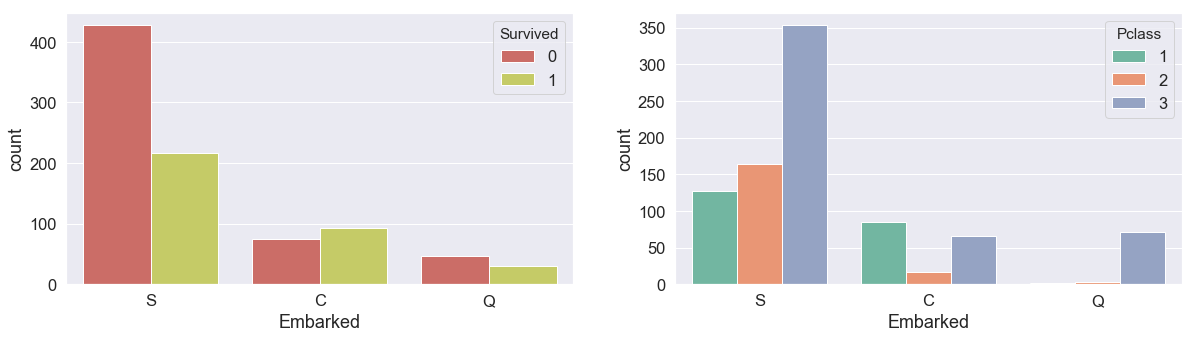

In [213]:
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.countplot(x='Embarked', data=train, hue='Survived')
plt.subplot(122)
sns.countplot(x='Embarked', hue='Pclass', data=train, palette='Set2')
plt.show()

# 3. Predicting the Survived feature in test set

We will use a logistic regression in order to predict the Survived feature in test set. 

## 3.1. Converting categorical features

In [214]:
sex_train = pd.get_dummies(train['Sex'],drop_first=True)
sex_test  = pd.get_dummies(test['Sex'],drop_first=True)

train.drop(['Sex','Embarked'],axis=1,inplace=True)
test.drop(['Sex','Embarked'],axis=1,inplace=True)

train = pd.concat([train,sex_train],axis=1)
test  = pd.concat([test,sex_test],axis=1)

In [215]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male
0,1,0,3,22.0,1,0,7.2500,1
1,2,1,1,38.0,1,0,71.2833,0
2,3,1,3,26.0,0,0,7.9250,0
3,4,1,1,35.0,1,0,53.1000,0
4,5,0,3,35.0,0,0,8.0500,1


In [216]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male
0,892,3,34.5,0,0,7.8292,1
1,893,3,47.0,1,0,7.0000,0
2,894,2,62.0,0,0,9.6875,1
3,895,3,27.0,0,0,8.6625,1
4,896,3,22.0,1,1,12.2875,0


## 3.2. Building logistic regression model

In [217]:
X_train = train.drop(['Survived', 'PassengerId'], axis=1)
y_train = train['Survived']
X_test = test.drop(['PassengerId'], axis=1)

In [218]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Users/diego/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [219]:
coefficients = pd.DataFrame(logmodel.coef_[0], X_train.columns)
coefficients.columns = ['Coefficient']
coefficients

,Coefficient
Pclass,-0.884099
Age,-0.030917
SibSp,-0.317202
Parch,-0.087931
Fare,0.004980
male,-2.499372


## 3.3. Predictions

In [224]:
predictions = logmodel.predict(X_test)
np.savetxt("predictions.csv", predictions, delimiter=",")

### 3.3.1. Validation of the model

### Insights

1. As we expected, the sex is the most important feature in order to figure out if a passenger died or not. 
2. The second most important feature is, as we previously inferred, the class. 